# Data description & Problem statement: 
This data set contains a total 5820 evaluation scores provided by students from Gazi University in Ankara (Turkey). There is a total of 28 course specific questions and additional 5 attributes. Please check the description at: http://archive.ics.uci.edu/ml/datasets/turkiye+student+evaluation

* Dataset is imbalanced. The data has 5820 rows and 33 variables.
* This is a classification problem. The classification goal is to predict number of times the student is taking this course: 0 (passed) and >0 (failed).

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial SVM model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of SVM model: Find the best SVM model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best SVM model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/wine quality/winequality-red.csv', sep=';') 

df['quality']=df['quality'].map({3:'L', 4:'L', 5:'L', 6:'L', 7:'H', 8:'H'})
df['quality']=df['quality'].map({'L':0,  'H':1})

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,0
1,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,0
2,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,0
3,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,0
4,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
X=df.drop('quality', axis=1)
y=df['quality']

In [6]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Removing outliers:
remove_outliers(X_train, y_train, ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
      'pH', 'sulphates', 'alcohol'], thresh=9)

number of outliers removed :   2


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler=MinMaxScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [9]:
# We build the Initial Model & Cross-Validation:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=SVC(C=10, gamma=0.1,  random_state=42)
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.86727855 0.82608696 0.89522947 0.82608696 0.84571256] 

Accuracy: 0.85 (+/- 0.03)


In [10]:
# Grid-Serach for the best model parameters: 

# Rough Search (Round 1)
from sklearn.model_selection import GridSearchCV

param={'kernel':['rbf'], 'C': [0.1, 0.5, 1, 5, 10, 100, 1000], 'gamma':[0.1, 0.5, 1, 5, 10, 15, 20, 25]}

kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_search=GridSearchCV(SVC(class_weight='balanced'), param, cv=kfold, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
26,0.105012,0.027507,0.012078,0.004094,5,1,rbf,"{'C': 5, 'gamma': 1, 'kernel': 'rbf'}",0.867502,0.873745,...,0.860232,0.877581,0.018682,1,0.916077,0.919791,0.906719,0.921908,0.916124,0.005817
25,0.109092,0.028693,0.017330,0.014218,5,0.5,rbf,"{'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}",0.865053,0.868919,...,0.857915,0.874846,0.019267,2,0.900043,0.907240,0.892211,0.908591,0.902021,0.006530
18,0.108066,0.029715,0.008702,0.001507,1,1,rbf,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.874282,0.863900,...,0.854151,0.874699,0.019666,3,0.897426,0.902358,0.887478,0.902262,0.897381,0.006055


In [11]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'C': 5, 'gamma': 1, 'kernel': 'rbf'}
Best validation accuracy:  0.88 (+/- 0.02)
Test score:  0.89


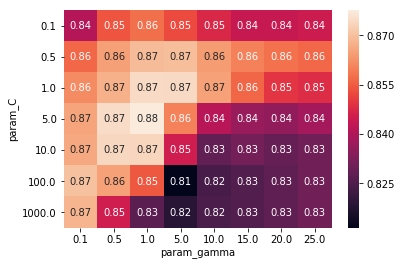

In [12]:
h=G[["param_C", "param_gamma", "mean_test_score"]].pivot_table(index="param_C", columns="param_gamma", values="mean_test_score")
sns.heatmap(h, annot=True)

Confusion matrix, without normalization
[[280  64]
 [ 10  46]]
Normalized confusion matrix
[[0.81 0.19]
 [0.18 0.82]]


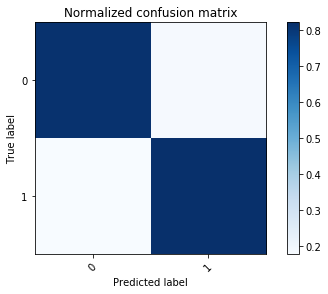

In [13]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [14]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.97      0.81      0.88       344
          1       0.42      0.82      0.55        56

avg / total       0.89      0.81      0.84       400



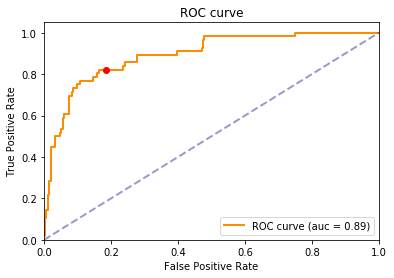

In [15]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test), grid_search.decision_function(X_test) , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.decision_function(X_test))

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

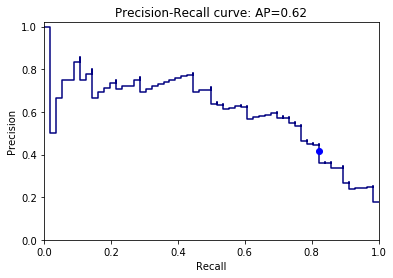

In [20]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.decision_function(X_test),  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.decision_function(X_test))

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot(cm_normalized[1,1], cm[1,1]/(cm[1,1]+cm[0,1]),  'ob')
plt.show()